# Klasifikasi: Accuracy, P/R/F1, ROC–AUC + Confusion Matrix

{'accuracy': 0.9, 'precision': 1.0, 'recall': 0.75, 'f1': 0.8571428571428571, 'roc_auc': np.float64(1.0)}

Classification Report:
               precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       1.00      0.75      0.86         4

    accuracy                           0.90        10
   macro avg       0.93      0.88      0.89        10
weighted avg       0.91      0.90      0.90        10



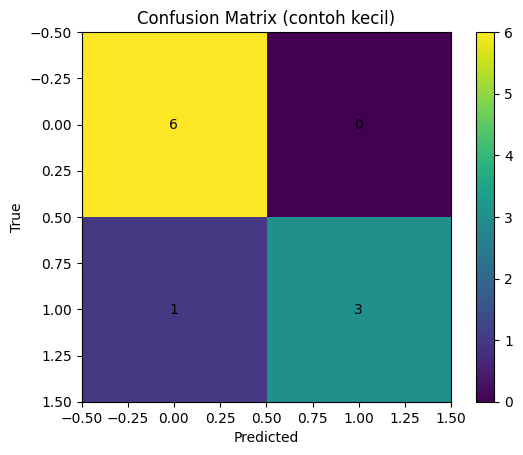

In [1]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Contoh kecil
y_true = np.array([1,0,1,0,0,1,0,0,1,0])
y_pred = np.array([1,0,0,0,0,1,0,0,1,0])         # prediksi kelas (0/1)
y_proba = np.array([0.9,0.2,0.4,0.1,0.3,0.8,0.2,0.2,0.7,0.1])  # skor/probabilitas kelas 1

acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
auc = roc_auc_score(y_true, y_proba)

print({"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "roc_auc": auc})
print("\nClassification Report:\n", classification_report(y_true, y_pred, zero_division=0))

cm = confusion_matrix(y_true, y_pred)
fig = plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix (contoh kecil)')
plt.xlabel('Predicted'); plt.ylabel('True')
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha='center', va='center')
plt.colorbar(); plt.show()


# Regresi: MAE & MSE

In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_true = np.array([10, 12, 13, 9])
y_pred = np.array([11, 11, 15, 8])

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
print({"MAE": mae, "MSE": mse})


{'MAE': 1.25, 'MSE': 1.75}


# Contoh Leakage (SALAH vs BENAR)

In [4]:
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Dataset sederhana
df = pd.DataFrame({
    "x_num": [1,2,3,4,5,6,7,8],
    "x_cat": ["a","a","b","b","a","b","a","b"],
    "y":     [0,0,0,1,0,1,0,1]
})

# --- SALAH: scaling sebelum split (LEAKAGE) ---
scaler = StandardScaler()
df["x_num_scaled_wrong"] = scaler.fit_transform(df[["x_num"]])  # fit di seluruh data (jangan!)
X_wrong = df[["x_num_scaled_wrong","x_cat"]]; y = df["y"]
X_tr, X_te, y_tr, y_te = train_test_split(X_wrong, y, test_size=0.25, random_state=42, stratify=y)
# (… lalu encode x_cat manual dsb. → ini pola rawan leakage)

# --- BENAR: split dulu, lalu pakai Pipeline ---
num_cols = ["x_num"]
cat_cols = ["x_cat"]

num_pipe = Pipeline([("imp", SimpleImputer(strategy="median")),
                     ("sc", StandardScaler())])
cat_pipe = Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                     ("oh", OneHotEncoder(handle_unknown="ignore"))])

pre = ColumnTransformer([("num", num_pipe, num_cols),
                         ("cat", cat_pipe, cat_cols)])

X = df[num_cols + cat_cols]; y = df["y"]
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

clf = Pipeline([("preprocess", pre),
                ("model", LogisticRegression(max_iter=500))])

clf.fit(X_tr, y_tr)
print("Pipeline OK (anti-leakage). Score (train/test):",
      clf.score(X_tr, y_tr), clf.score(X_te, y_te))


Pipeline OK (anti-leakage). Score (train/test): 1.0 0.5
